# Computer Vision

Studi Kasus:

Klasifikasi gambar kupu-kupu dari 8 jenis berbeda yang masing-masing jenis memiliki kurang lebih 100 gambar berbeda.

Model yang akan saya gunakan antara lain
1.   MobileNet-v2
2.   AlexNet
3.   Inception-v3


## Implementasi

### Library and Preparation

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score

# Keperluan untuk splitting data
from sklearn.model_selection import train_test_split

# Menggunakan AlexNet
alexnet = torchvision.models.alexnet(pretrained=True)

# Menggunakan MobileNetV2
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)

# Menggunakan InceptionV3
inception_v3 = torchvision.models.inception_v3(pretrained=True)

# Transformasi untuk preprocessing data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 76.9MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remove

### Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

folder_path = '/content/drive/My Drive/Computer Vision/butterfly_dataset'

os.listdir(folder_path)

['kupu_jojo',
 'kupu_raja_limau',
 'kupu_hijau_biru',
 'kupu_raja_helena',
 'kupu_pantat_merah',
 'kupu_jarak',
 'kupu_harimau_kuning_hijau',
 'kupu_batik_cap']

In [5]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root=folder_path, transform=transform)

### Preprocessing

In [6]:
# 1. Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Memisahkan Data Validasi
dataset = ImageFolder(root=folder_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
batch_size = 32

In [8]:
# Buat DataLoader untuk data latih dan data validasi
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Modeling

In [9]:
# Import model sudah dilakukan di tahap preparation

# 1. MobileNet-v2

# Ambil dataset asli sebelum dibagi
original_dataset = train_dataset.dataset

# Hitung jumlah kelas dari dataset asli
num_classes = len(original_dataset.classes)

# Membuat model baru
num_features = mobilenet_v2.features[-1].out_channels  # Jumlah fitur masuk untuk lapisan terakhir
mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# Menentukan device yang akan digunakan (CPU atau CUDA jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
mobilenet_v2 = mobilenet_v2.to(device)

# Definisi loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.001)


#### Training model

In [10]:
# Tentukan jumlah epoch
num_epochs = 10

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)

# Tentukan device yang akan digunakan (CPU atau CUDA jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
mobilenet_v2 = mobilenet_v2.to(device)

# Loop pelatihan untuk setiap epoch
for epoch in range(num_epochs):
    # Set model ke mode pelatihan
    mobilenet_v2.train()

    # Inisialisasi nilai loss dan jumlah batch yang benar
    running_loss = 0.0
    correct = 0

    # Loop pelatihan untuk setiap batch dalam DataLoader
    for images, labels in train_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Proses forward pass: menghitung output dari model
        outputs = mobilenet_v2(images)

        # Hitung loss
        loss = criterion(outputs, labels)

        # Proses backward pass: hitung gradien dari loss terhadap parameter
        loss.backward()

        # Optimize parameter
        optimizer.step()

        # Hitung statistik untuk logging
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / len(train_dataset)

    # Cetak statistik pelatihan untuk setiap epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch 1/10, Loss: 0.5828, Accuracy: 0.8176
Epoch 2/10, Loss: 0.1966, Accuracy: 0.9355
Epoch 3/10, Loss: 0.2874, Accuracy: 0.9292
Epoch 4/10, Loss: 0.2815, Accuracy: 0.9214
Epoch 5/10, Loss: 0.2028, Accuracy: 0.9355
Epoch 6/10, Loss: 0.1125, Accuracy: 0.9686
Epoch 7/10, Loss: 0.1597, Accuracy: 0.9670
Epoch 8/10, Loss: 0.2215, Accuracy: 0.9387
Epoch 9/10, Loss: 0.2129, Accuracy: 0.9450
Epoch 10/10, Loss: 0.1815, Accuracy: 0.9418


#### Model Evaluation

In [11]:
# Set model ke mode evaluasi
mobilenet_v2.eval()

# Inisialisasi variabel untuk evaluasi
correct = 0
total = 0

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = mobilenet_v2(images)

        # Ambil prediksi
        _, predicted = torch.max(outputs, 1)

        # Hitung jumlah data yang diprediksi dengan benar
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = correct / total
print(f'Accuracy on validation set: {accuracy:.2f}')

Accuracy on validation set: 0.97


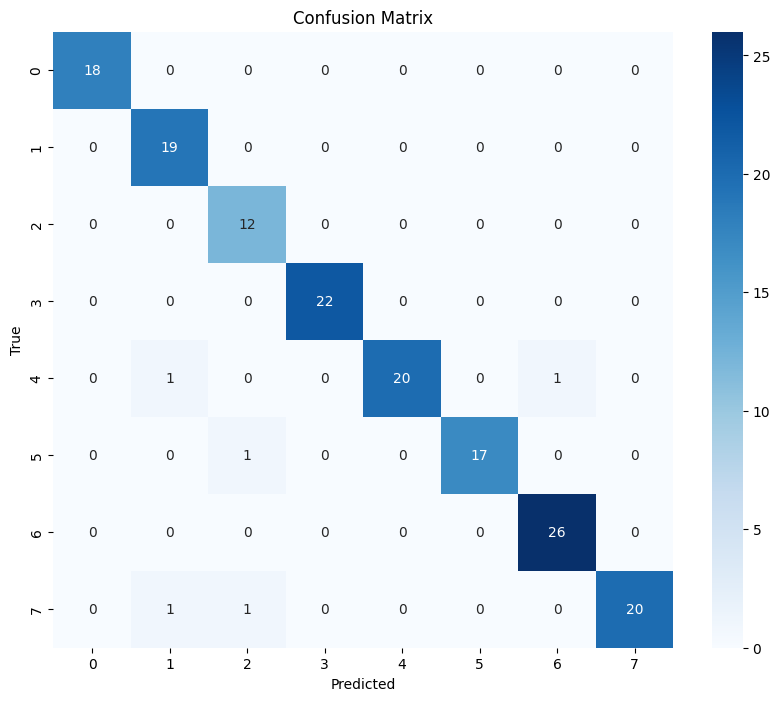

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mengumpulkan label sebenarnya
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Hitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Menghitung TP, FP, TN, dan FN untuk setiap label
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    # Menampilkan nilai untuk setiap label
    print(f'Label {i+1}:')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive (FP): {fp}')
    print(f'True Negative (TN): {tn}')
    print(f'False Negative (FN): {fn}')
    print()

Label 1:
True Positive (TP): 18
False Positive (FP): 0
True Negative (TN): 141
False Negative (FN): 0

Label 2:
True Positive (TP): 19
False Positive (FP): 2
True Negative (TN): 138
False Negative (FN): 0

Label 3:
True Positive (TP): 12
False Positive (FP): 2
True Negative (TN): 145
False Negative (FN): 0

Label 4:
True Positive (TP): 22
False Positive (FP): 0
True Negative (TN): 137
False Negative (FN): 0

Label 5:
True Positive (TP): 20
False Positive (FP): 0
True Negative (TN): 137
False Negative (FN): 2

Label 6:
True Positive (TP): 17
False Positive (FP): 0
True Negative (TN): 141
False Negative (FN): 1

Label 7:
True Positive (TP): 26
False Positive (FP): 1
True Negative (TN): 132
False Negative (FN): 0

Label 8:
True Positive (TP): 20
False Positive (FP): 0
True Negative (TN): 137
False Negative (FN): 2



In [26]:
from sklearn.metrics import classification_report

# Tampilkan laporan klasifikasi
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.90      1.00      0.95        19
           2       0.86      1.00      0.92        12
           3       1.00      1.00      1.00        22
           4       1.00      0.91      0.95        22
           5       1.00      0.94      0.97        18
           6       0.96      1.00      0.98        26
           7       1.00      0.91      0.95        22

    accuracy                           0.97       159
   macro avg       0.97      0.97      0.97       159
weighted avg       0.97      0.97      0.97       159



#### Comparing Model

##### AlexNet

Modeling

In [13]:
# Ambil dataset asli sebelum dibagi
original_dataset = train_dataset.dataset

# Hitung jumlah kelas dari dataset asli
num_classes = len(original_dataset.classes)

# Membuat model baru untuk klasifikasi
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features, num_classes)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)

# Menentukan device yang akan digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
alexnet = alexnet.to(device)

Training Model

In [14]:
# Loop pelatihan untuk setiap epoch
for epoch in range(num_epochs):
    # Set model ke mode pelatihan
    alexnet.train()

    # Inisialisasi nilai loss dan jumlah batch yang benar
    running_loss = 0.0
    correct = 0

    # Loop pelatihan untuk setiap batch dalam DataLoader
    for images, labels in train_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Proses forward pass: menghitung output dari model
        outputs = alexnet(images)

        # Hitung loss
        loss = criterion(outputs, labels)

        # Proses backward pass: hitung gradien dari loss terhadap parameter
        loss.backward()

        # Optimize parameter
        optimizer.step()

        # Hitung statistik untuk logging
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / len(train_dataset)

    # Cetak statistik pelatihan untuk setiap epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch 1/10, Loss: 1.8265, Accuracy: 0.4277
Epoch 2/10, Loss: 1.5032, Accuracy: 0.4811
Epoch 3/10, Loss: 1.4420, Accuracy: 0.4906
Epoch 4/10, Loss: 1.9033, Accuracy: 0.3491
Epoch 5/10, Loss: 2.0816, Accuracy: 0.1415
Epoch 6/10, Loss: 2.0602, Accuracy: 0.1651
Epoch 7/10, Loss: 2.0527, Accuracy: 0.1635
Epoch 8/10, Loss: 2.0353, Accuracy: 0.1651
Epoch 9/10, Loss: 1.9327, Accuracy: 0.2044
Epoch 10/10, Loss: 1.9041, Accuracy: 0.1950


Model Evaluation

In [16]:
# Set model ke mode evaluasi
alexnet.eval()

# Inisialisasi variabel untuk evaluasi
correct = 0
total = 0

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)

        # Ambil prediksi
        _, predicted = torch.max(outputs, 1)

        # Hitung jumlah data yang diprediksi dengan benar
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = correct / total
print(f'Accuracy on validation set of Alexnet Model: {accuracy:.2f}')

Accuracy on validation set of Alexnet Model: 0.14


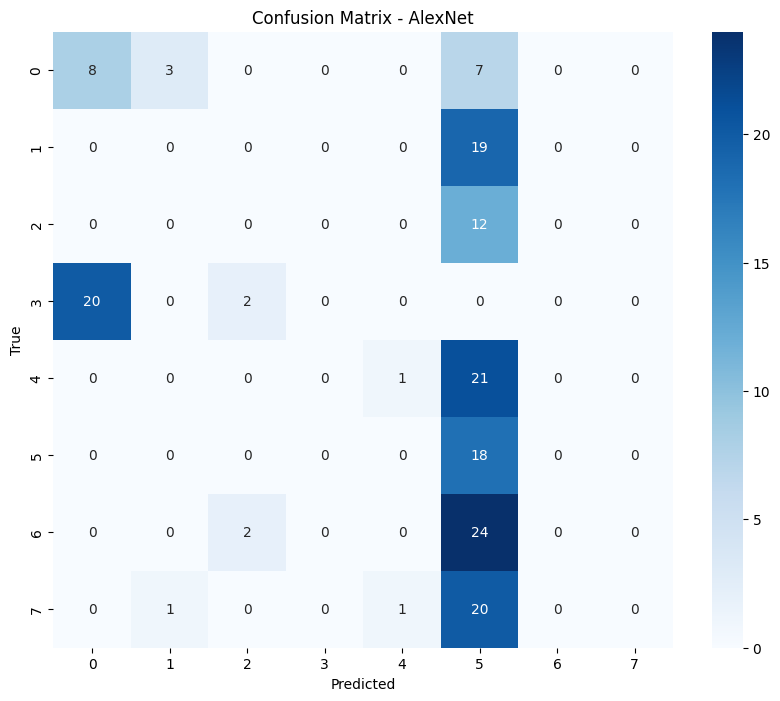

              precision    recall  f1-score   support

           0       0.29      0.44      0.35        18
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        22
           4       0.50      0.05      0.08        22
           5       0.15      1.00      0.26        18
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00        22

    accuracy                           0.17       159
   macro avg       0.12      0.19      0.09       159
weighted avg       0.12      0.17      0.08       159



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Mengumpulkan label sebenarnya dan prediksi
true_labels = []
predicted_labels = []

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Hitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - AlexNet')
plt.show()

# Tampilkan laporan klasifikasi
report = classification_report(true_labels, predicted_labels)
print(report)

In [28]:
# Menghitung TP, FP, TN, dan FN untuk setiap label
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    # Menampilkan nilai untuk setiap label
    print(f'Label {i+1}:')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive (FP): {fp}')
    print(f'True Negative (TN): {tn}')
    print(f'False Negative (FN): {fn}')
    print()

Label 1:
True Positive (TP): 8
False Positive (FP): 20
True Negative (TN): 121
False Negative (FN): 10

Label 2:
True Positive (TP): 0
False Positive (FP): 4
True Negative (TN): 136
False Negative (FN): 19

Label 3:
True Positive (TP): 0
False Positive (FP): 4
True Negative (TN): 143
False Negative (FN): 12

Label 4:
True Positive (TP): 0
False Positive (FP): 0
True Negative (TN): 137
False Negative (FN): 22

Label 5:
True Positive (TP): 1
False Positive (FP): 1
True Negative (TN): 136
False Negative (FN): 21

Label 6:
True Positive (TP): 18
False Positive (FP): 103
True Negative (TN): 38
False Negative (FN): 0

Label 7:
True Positive (TP): 0
False Positive (FP): 0
True Negative (TN): 133
False Negative (FN): 26

Label 8:
True Positive (TP): 0
False Positive (FP): 0
True Negative (TN): 137
False Negative (FN): 22



##### Inception-V3

Preprocessing

In [18]:
# Preprocessing khusus untuk model InceptionV3
train_transform_inception = transforms.Compose([
    transforms.Resize(342),  # Resizing gambar ke ukuran 342x342 piksel
    transforms.RandomResizedCrop(299),  # Random crop dan resize menjadi 299x299 piksel
    transforms.RandomHorizontalFlip(),  # Flip horizontal secara acak
    transforms.ToTensor(),  # Mengubah gambar menjadi tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi tensor
])

# Memuat dataset dan menerapkan transformasi
dataset_inception = ImageFolder(root=folder_path, transform=train_transform_inception)

# Memisahkan data validasi
train_size = int(0.8 * len(dataset_inception))
val_size = len(dataset_inception) - train_size
train_dataset_inception, val_dataset_inception = random_split(dataset_inception, [train_size, val_size])

# Membuat DataLoader untuk data pelatihan dan data validasi
train_loader_inception = DataLoader(train_dataset_inception, batch_size=batch_size, shuffle=True)
val_loader_inception = DataLoader(val_dataset_inception, batch_size=batch_size, shuffle=False)

In [19]:
batch_size = 32

Modeling

In [20]:
# Ambil dataset asli sebelum dibagi
original_dataset_inception = train_dataset_inception.dataset

# Hitung jumlah kelas dari dataset asli
num_classes_inception = len(original_dataset_inception.classes)

# Membuat model baru untuk klasifikasi
num_features_inception = inception_v3.fc.in_features
inception_v3.fc = nn.Linear(num_features_inception, num_classes_inception)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception_v3.parameters(), lr=0.001)

# Menentukan device yang akan digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
inception_v3 = inception_v3.to(device)

Training Model

In [21]:
# Loop pelatihan untuk setiap epoch
for epoch in range(num_epochs):
    # Set model ke mode pelatihan
    inception_v3.train()

    # Inisialisasi nilai loss dan jumlah batch yang benar
    running_loss = 0.0
    correct = 0

    # Loop pelatihan untuk setiap batch dalam DataLoader
    for images, labels in train_loader_inception:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Proses forward pass: menghitung output dari model
        outputs = inception_v3(images)

        # Ambil logits dari outputs
        logits = outputs.logits

        # Hitung loss
        loss = criterion(logits, labels)

        # Proses backward pass: hitung gradien dari loss terhadap parameter
        loss.backward()

        # Optimize parameter
        optimizer.step()

        # Hitung statistik untuk logging
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = running_loss / len(train_dataset_inception)
    epoch_acc = correct / len(train_dataset_inception)

    # Cetak statistik pelatihan untuk setiap epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch 1/10, Loss: 0.5015, Accuracy: 0.8585
Epoch 2/10, Loss: 0.2390, Accuracy: 0.9261
Epoch 3/10, Loss: 0.2854, Accuracy: 0.9277
Epoch 4/10, Loss: 0.2760, Accuracy: 0.9355
Epoch 5/10, Loss: 0.3198, Accuracy: 0.9182
Epoch 6/10, Loss: 0.1714, Accuracy: 0.9403
Epoch 7/10, Loss: 0.3324, Accuracy: 0.9009
Epoch 8/10, Loss: 0.1775, Accuracy: 0.9434
Epoch 9/10, Loss: 0.2192, Accuracy: 0.9261
Epoch 10/10, Loss: 0.1340, Accuracy: 0.9560


Model Evaluation

In [29]:
# Set model ke mode evaluasi
inception_v3.eval()

# Inisialisasi variabel untuk evaluasi
correct = 0
total = 0

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader_inception:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = inception_v3(images)

        # Ambil prediksi
        _, predicted = torch.max(outputs, 1)  # Mengambil nilai prediksi langsung

        # Hitung jumlah data yang diprediksi dengan benar
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = correct / total
print(f'Accuracy on validation set of Inception-v3 Model: {accuracy:.2f}')


Accuracy on validation set of Inception-v3 Model: 0.97


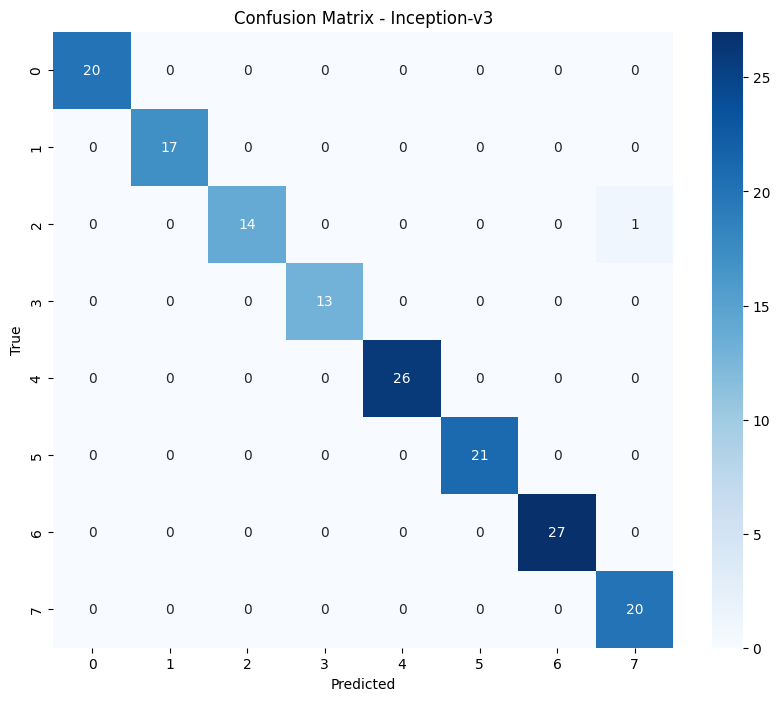

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        17
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        27
           7       0.95      1.00      0.98        20

    accuracy                           0.99       159
   macro avg       0.99      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159



In [30]:
# Mengumpulkan label sebenarnya dan prediksi
true_labels = []
predicted_labels = []

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader_inception:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v3(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Hitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Inception-v3')
plt.show()

# Tampilkan laporan klasifikasi
report = classification_report(true_labels, predicted_labels)
print(report)

In [31]:
# Menghitung TP, FP, TN, dan FN untuk setiap label
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    # Menampilkan nilai untuk setiap label
    print(f'Label {i+1}:')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive (FP): {fp}')
    print(f'True Negative (TN): {tn}')
    print(f'False Negative (FN): {fn}')
    print()

Label 1:
True Positive (TP): 20
False Positive (FP): 0
True Negative (TN): 139
False Negative (FN): 0

Label 2:
True Positive (TP): 17
False Positive (FP): 0
True Negative (TN): 142
False Negative (FN): 0

Label 3:
True Positive (TP): 14
False Positive (FP): 0
True Negative (TN): 144
False Negative (FN): 1

Label 4:
True Positive (TP): 13
False Positive (FP): 0
True Negative (TN): 146
False Negative (FN): 0

Label 5:
True Positive (TP): 26
False Positive (FP): 0
True Negative (TN): 133
False Negative (FN): 0

Label 6:
True Positive (TP): 21
False Positive (FP): 0
True Negative (TN): 138
False Negative (FN): 0

Label 7:
True Positive (TP): 27
False Positive (FP): 0
True Negative (TN): 132
False Negative (FN): 0

Label 8:
True Positive (TP): 20
False Positive (FP): 1
True Negative (TN): 138
False Negative (FN): 0



### Arsitektur Model

In [32]:
from torchsummary import summary

# Menampilkan arsitektur AlexNet
summary(alexnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [34]:
from torchsummary import summary

# Menampilkan arsitektur Inception-v3
summary(inception_v3, input_size=(3, 299, 299))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [35]:
from torchsummary import summary

# Menampilkan arsitektur MobileNetV2
summary(mobilenet_v2, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,